<a href="https://colab.research.google.com/github/millerinfante-sys/Energy-Storage-Project-Battery-Systems-for-Vehicles-and-Grid/blob/main/Energy_Storage_Project_Battery_Systems_for_vehicles_and_grid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Iniciando el análisis de datos de la batería ---

--- Análisis de Datos ---
Número total de puntos de datos: 1000

Estimación de SOC completada (Método de Conteo de Culombios).
   - SOH Mínimo (al final del ciclo o registrado): 83.96%)

--- Cálculo de C-Rate ---
C-Rate: 3.99C
Número total de celdas requeridas: 649 celdas

--- Dimensionamiento del Sistema de Baterías ---
Configuración del Paquete (N_p x N_s): 6P109S
Voltaje Real del Paquete: 403.30 V
Capacidad de Energía Real: 60.50 kWh
Número total de celdas: 654

--- Creando Visualizaciones Separadas (Gráficos 1 a 4) ---

--- Creando Gráfico 5: Temperatura, Eficiencia (SOH) y Celdas/kWh (Suavizado Aplicado) ---

--- Creando Gráfico 6: Comparación de Primer vs Último Ciclo (Carga/Descarga) ---
Error: No se detectó el inicio de la primera descarga. No se puede definir el primer ciclo.

Celdas requeridas por 1 kWh: 11 celdas.

Mostrando los 6 gráficos...


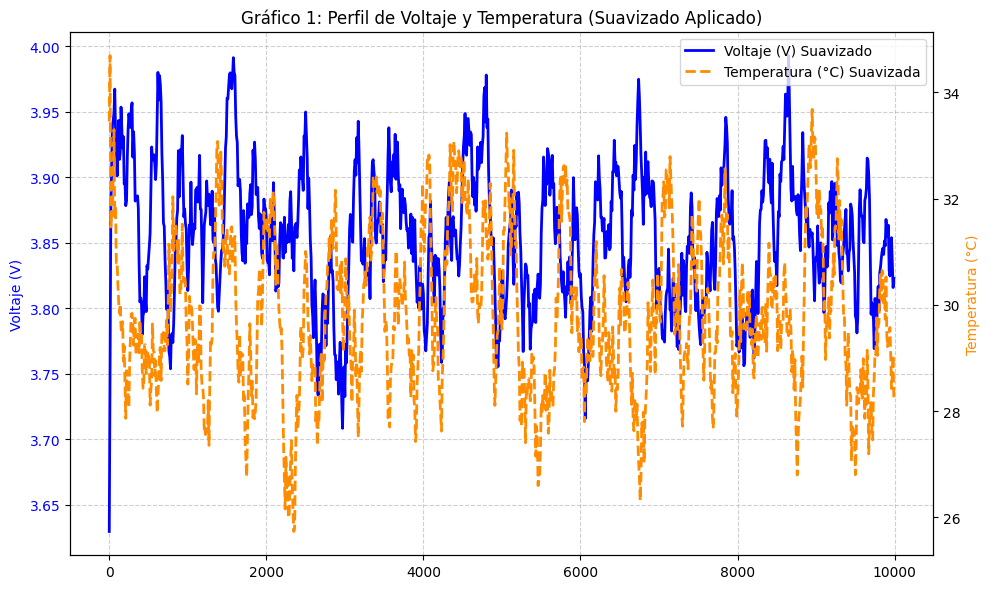

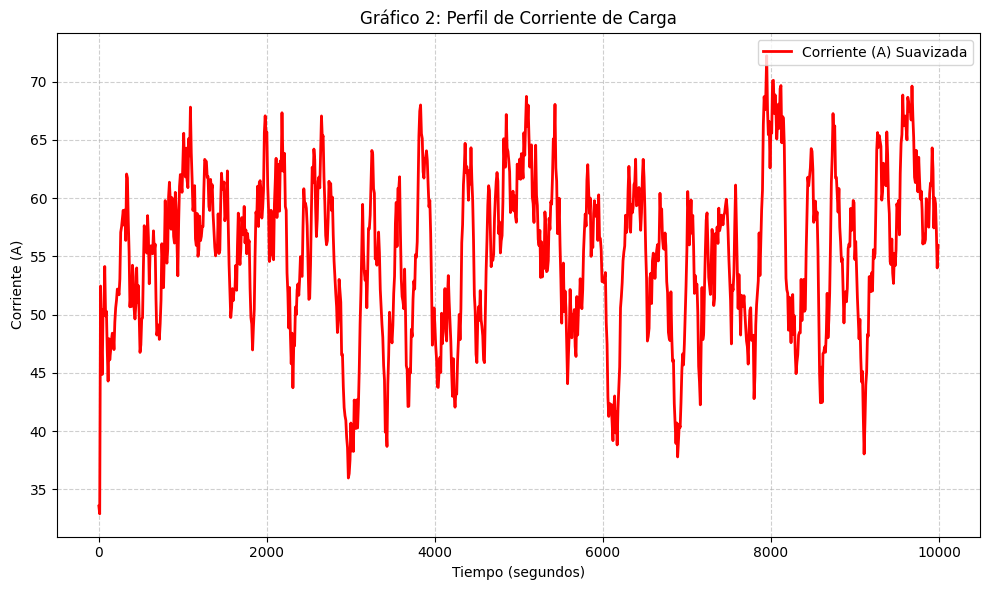

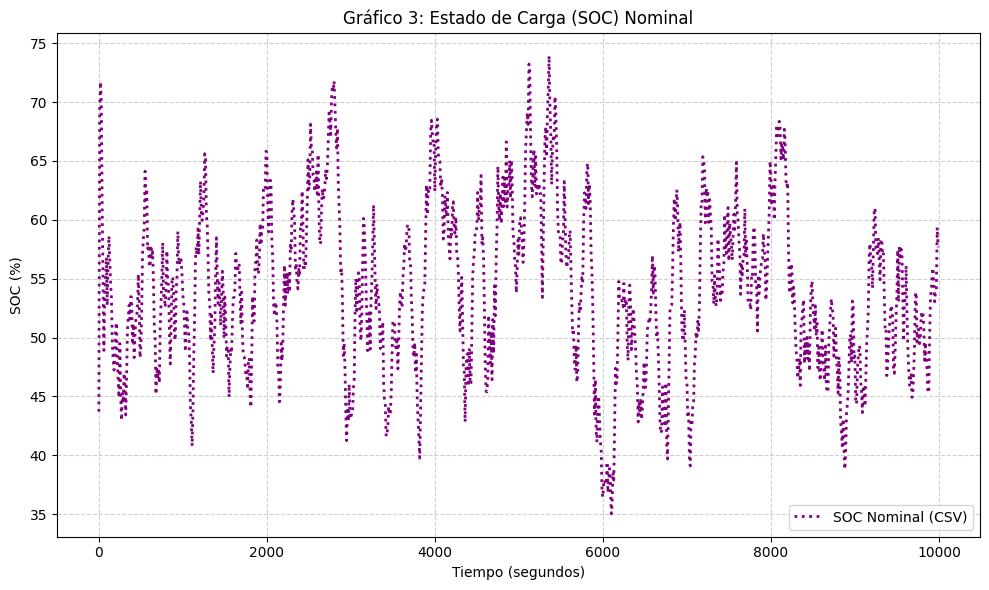

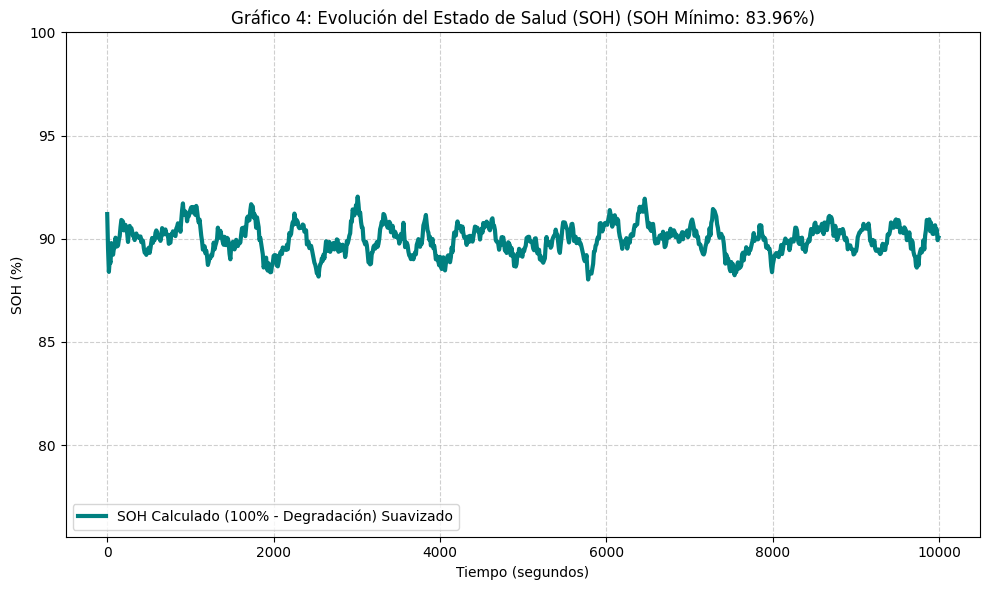

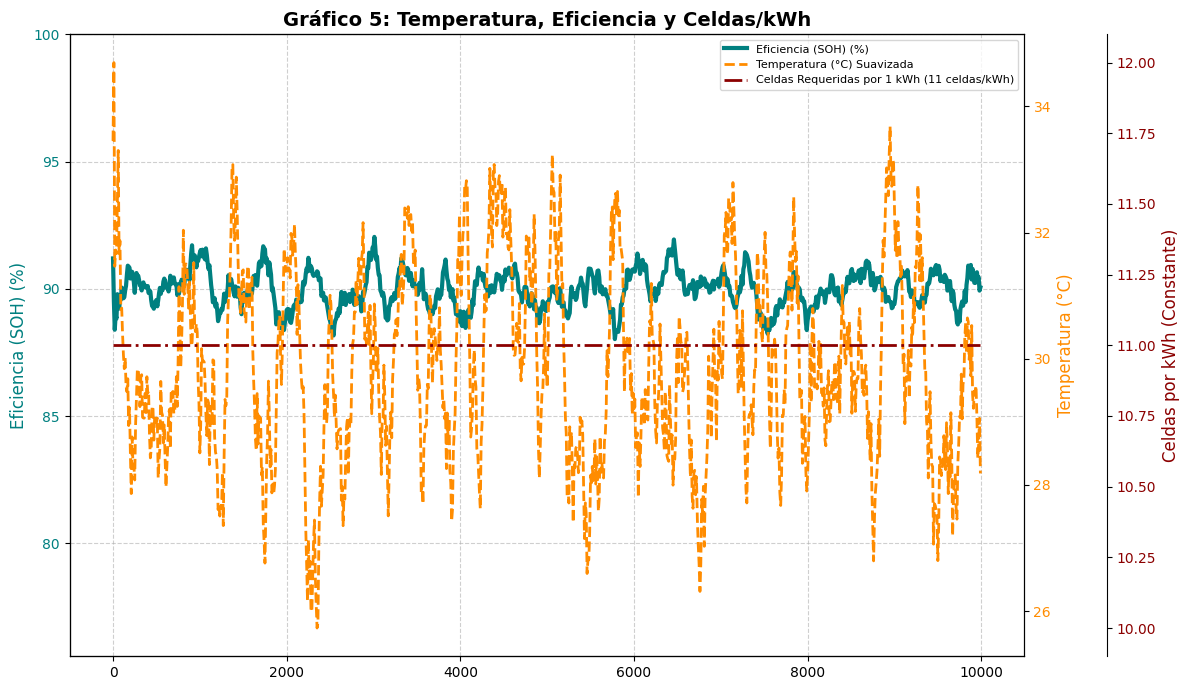


--- Análisis de datos completado ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# ====================================================================
# CLASE 1: BatteryDataProcessor - Análisis de Datos y Visualización
# ====================================================================

class BatteryDataProcessor:
    """
    Clase para importar, analizar y visualizar datos de rendimiento de la batería.
    """
    def __init__(self, file_path, cell_specs):
        """Inicializa con la ruta al archivo CSV y las especificaciones de la celda."""
        self.file_path = file_path
        self.cell_specs = cell_specs
        self.data = self._load_data()

        # Parámetros de suavizado
        self.SMOOTHING_WINDOW = 30
        self.MILD_SMOOTHING_WINDOW = 10
        self.soh_value = 100.0

        self.cells_per_kwh = 0

    def _load_data(self):
        """Carga y parsea el archivo de datos de la batería."""
        try:
            df = pd.read_csv(self.file_path)

            df.rename(columns={
                'Voltage (V)': 'Voltage_V',
                'Current (A)': 'Current_A',
                'Battery Temp (°C)': 'Temperature_C',
                'SOC (%)': 'SOC_Initial',
                'Degradation Rate (%)': 'Degradation_Rate_Perc'
            }, inplace=True)

            df['Voltage_V'] = pd.to_numeric(df['Voltage_V'], errors='coerce')
            df['Current_A'] = pd.to_numeric(df['Current_A'], errors='coerce')
            df['Temperature_C'] = pd.to_numeric(df['Temperature_C'], errors='coerce')
            df['SOC_Initial'] = pd.to_numeric(df['SOC_Initial'], errors='coerce')
            df['Degradation_Rate_Perc'] = pd.to_numeric(df['Degradation_Rate_Perc'], errors='coerce')

            df['Time_s'] = df.index * 10

            return df.dropna(subset=['Voltage_V', 'Current_A', 'Temperature_C', 'SOC_Initial', 'Degradation_Rate_Perc'])

        except (FileNotFoundError, KeyError) as e:
            print(f"Error al cargar datos: {e}")
            return pd.DataFrame()

    def data_analysis(self):
        """Muestra un resumen del análisis de datos."""
        if self.data.empty: return
        print("\n--- Análisis Inicial de Datos ---")
        print(f"Puntos de datos procesados: {len(self.data)}")

    def estimate_soc_coulomb_counting(self, nominal_capacity_Ah):
        """Implementa la estimación de State of Charge (SOC) usando Conteo de Culombios."""
        if self.data.empty:
            self.data['SOC_calc'] = 0
            return

        time_diff_s = self.data['Time_s'].diff().fillna(0)
        current_data = self.data['Current_A']
        delta_charge_Ah = current_data * (time_diff_s / 3600)
        soc_initial_from_data = self.data['SOC_Initial'].iloc[0] / 100.0
        initial_charge_Ah = soc_initial_from_data * nominal_capacity_Ah
        charge_remaining_Ah = initial_charge_Ah + delta_charge_Ah.cumsum()
        self.data['SOC_calc'] = (charge_remaining_Ah / nominal_capacity_Ah) * 100
        self.data['SOC_calc'] = self.data['SOC_calc'].clip(lower=0, upper=100)
        print(f"Cálculo de SOC (Conteo de Culombios) completado.")

    def estimate_soh(self):
        """Calcula el State of Health (SOH)."""
        if self.data.empty or 'Degradation_Rate_Perc' not in self.data.columns:
            self.soh_value = 100.0
            return self.soh_value

        self.data['SOH_calc'] = 100 - self.data['Degradation_Rate_Perc']
        final_soh = self.data['SOH_calc'].min()
        self.soh_value = final_soh
        print(f"SOH Mínimo registrado: {final_soh:.2f}%")
        return final_soh

    def set_cells_per_kwh(self):
        """Calcula y establece el número de celdas por kWh para la visualización de Dimensionamiento."""
        cell_energy_wh = self.cell_specs['voltage_V'] * self.cell_specs['capacity_Ah']
        self.cells_per_kwh = np.ceil(1000 / cell_energy_wh).astype(int)

    # ====================================================
    # Gráfica: Dimensionamiento, SOH y Temperatura
    # ====================================================
    def visualize_sizing_and_degradation(self):
        """Genera el Dimensionamiento, SOH y Temperatura."""
        if self.data.empty or 'SOH_calc' not in self.data.columns: return

        print("\n--- Creando Gráfica de Dimensionamiento, SOH y Temperatura ---")

        time_units = self.data['Time_s']
        x_label = 'Tiempo (segundos)'

        smoothed_soh = self.data['SOH_calc'].rolling(
            window=self.SMOOTHING_WINDOW, min_periods=1
        ).mean()
        smoothed_temp = self.data['Temperature_C'].rolling(
            window=self.SMOOTHING_WINDOW, min_periods=1
        ).mean()

        plt.figure(figsize=(12, 7))

        # Eje Y Principal (SOH/Eficiencia)
        ax1 = plt.gca()
        ax1.plot(time_units, smoothed_soh, label='Eficiencia (SOH) (%)', color='teal', linewidth=3)
        ax1.set_ylabel('Eficiencia (SOH) (%)', color='teal', fontsize=12)
        ax1.tick_params(axis='y', labelcolor='teal')
        ax1.set_ylim(self.data['SOH_calc'].min() * 0.9, 100)
        ax1.set_title(f'Dimensionamiento, Eficiencia (SOH) y Temperatura', fontsize=14, fontweight='bold')
        ax1.grid(True, linestyle='--', alpha=0.6)

        # Eje Y Secundario 1 (Temperatura)
        ax2 = ax1.twinx()
        ax2.plot(time_units, smoothed_temp, label='Temperatura de la Celda (°C)', color='darkorange', linestyle='--', linewidth=2)
        ax2.set_ylabel(f'Temperatura (°C)', color='darkorange', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='darkorange')

        # Eje Y Secundario 2 (Celdas por kWh)
        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('outward', 60))

        cells_line = [self.cells_per_kwh] * len(time_units)

        ax3.plot(time_units, cells_line, label=f'Celdas Requeridas por 1 kWh ({self.cells_per_kwh} celdas/kWh)', color='darkred', linestyle='-.', linewidth=2)
        ax3.set_ylabel(f'Celdas por kWh (Constante)', color='darkred', fontsize=12)
        ax3.tick_params(axis='y', labelcolor='darkred')
        ax3.set_ylim(self.cells_per_kwh * 0.9, self.cells_per_kwh * 1.1)

        # Leyendas combinadas
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        lines3, labels3 = ax3.get_legend_handles_labels()
        ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper right', fontsize=8)
        plt.xlabel(x_label, fontsize=12)
        plt.tight_layout()


    # ====================================================
    # Gráficas: Perfiles Individuales
    # ====================================================
    def visualize_data(self):
        """Genera plots separados para las visualizaciones individuales."""
        if self.data.empty: return
        print("\n--- Creando Gráficas de Perfiles Individuales ---")

        time_units = self.data['Time_s']
        x_label = 'Tiempo (segundos)'

        # Aplicación del suavizado (internamente)
        smoothed_voltage = self.data['Voltage_V'].rolling(window=self.SMOOTHING_WINDOW, min_periods=1).mean()
        smoothed_current = self.data['Current_A'].rolling(window=self.SMOOTHING_WINDOW, min_periods=1).mean()
        smoothed_temp = self.data['Temperature_C'].rolling(window=self.SMOOTHING_WINDOW, min_periods=1).mean()
        smoothed_soc_initial = self.data['SOC_Initial'].rolling(window=self.SMOOTHING_WINDOW, min_periods=1).mean()

        # Perfil de Voltaje y Temperatura
        plt.figure(figsize=(10, 6))
        ax1 = plt.gca()
        ax1.plot(time_units, smoothed_voltage, label='Voltaje (V)', color='blue', linewidth=2)
        ax1.set_ylabel('Voltaje (V)', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.set_title('Perfil de Voltaje y Temperatura de la Celda', fontsize=14, fontweight='bold')
        ax1.grid(True, linestyle='--', alpha=0.6)
        ax1_twin = ax1.twinx()
        ax1_twin.plot(time_units, smoothed_temp, label='Temperatura (°C)', color='darkorange', linestyle='--', linewidth=2)
        ax1_twin.set_ylabel('Temperatura (°C)', color='darkorange')
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax1_twin.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        plt.xlabel(x_label)
        plt.tight_layout()

        # Corriente de Carga respecto al Tiempo
        plt.figure(figsize=(10, 6))
        plt.plot(time_units, smoothed_current, label='Corriente (A)', color='red', linewidth=2)
        plt.xlabel(x_label)
        plt.ylabel('Corriente (A)')
        plt.title('Corriente de Carga respecto al Tiempo', fontsize=14, fontweight='bold')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(loc='upper right')
        plt.tight_layout()

        # Estado de Carga (SOC) Nominal
        if 'SOC_Initial' in self.data.columns:
            plt.figure(figsize=(10, 6))
            plt.plot(time_units, smoothed_soc_initial, label='SOC Nominal (CSV)', color='purple', linestyle='-', linewidth=2)
            plt.xlabel(x_label)
            plt.ylabel('SOC (%)')
            plt.title('Estado de Carga (SOC) Nominal', fontsize=14, fontweight='bold')
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.legend(loc='lower right')
            plt.tight_layout()

        # Evolución del Estado de Salud (SOH)
        if 'SOH_calc' in self.data.columns:
            plt.figure(figsize=(10, 6))
            smoothed_soh = self.data['SOH_calc'].rolling(window=self.SMOOTHING_WINDOW, min_periods=1).mean()
            plt.plot(time_units, smoothed_soh, label='SOH Calculado (100% - Degradación)', color='teal', linewidth=3)
            plt.xlabel(x_label)
            plt.ylabel('SOH (%)')
            plt.title(f'Evolución del Estado de Salud (SOH) (SOH Mínimo: {self.soh_value:.2f}%)', fontsize=14, fontweight='bold')
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.ylim(self.data['SOH_calc'].min() * 0.9, 100)
            plt.legend(loc='lower left')
            plt.tight_layout()


# ====================================================================
# CLASE 2: SystemSizer - Calculadora y Dimensionamiento del Sistema
# ====================================================================

class SystemSizer:
    """Clase para dimensionar sistemas de baterías."""
    def __init__(self, cell_specifications):
        self.spec = cell_specifications

    def calculate_c_rate(self, current_A):
        """Calcula la C-Rate."""
        c_rate = current_A / self.spec['capacity_Ah']
        print(f"\n--- Cálculo de C-Rate ---")
        print(f"C-Rate: {c_rate:.2f}C")
        return c_rate

    def energy_storage_calculator(self, desired_energy_kWh):
        """Calcula el número de celdas requerido para una cantidad de energía deseada."""
        cell_energy_Wh = self.spec['voltage_V'] * self.spec['capacity_Ah']
        desired_energy_Wh = desired_energy_kWh * 1000
        num_cells = np.ceil(desired_energy_Wh / cell_energy_Wh).astype(int)
        print(f"Celdas requeridas para {desired_energy_kWh} kWh: {num_cells} celdas.")
        return num_cells

    def system_sizing(self, desired_energy_kWh, target_voltage_V):
        """Dimensiona un paquete de baterías para una aplicación específica."""
        num_cells = self.energy_storage_calculator(desired_energy_kWh)
        ns = np.ceil(target_voltage_V / self.spec['voltage_V']).astype(int)
        np_actual = np.ceil(num_cells / ns).astype(int)
        total_cells_actual = ns * np_actual
        pack_voltage_V = ns * self.spec['voltage_V']
        pack_energy_kWh = (pack_voltage_V * np_actual * self.spec['capacity_Ah']) / 1000

        print("\n--- Resultado del Dimensionamiento ---")
        print(f"Configuración del Paquete (N_p x N_s): {np_actual}P{ns}S")
        print(f"Voltaje real del paquete: {pack_voltage_V:.2f} V")
        print(f"Capacidad de energía real: {pack_energy_kWh:.2f} kWh")
        print(f"Número total de celdas utilizadas: {total_cells_actual}")

        return {'Total_Cells': total_cells_actual}

# ====================================================================
# FUNCIÓN DE ENTRADA DEL USUARIO
# ====================================================================

def get_user_input():
    """Solicita al usuario la energía deseada para el vehículo eléctrico."""
    while True:
        try:
            user_input = input("Ingresa la Energía Deseada del EV en kWh (ej: 50): ")
            desired_energy = float(user_input)
            if desired_energy <= 0:
                print("El valor debe ser positivo. Inténtalo de nuevo.")
                continue
            return desired_energy
        except ValueError:
            print("Entrada inválida. Por favor, ingresa un número.")

# ====================================================================
# FUNCIÓN PRINCIPAL DE EJECUCIÓN DEL PROYECTO
# ====================================================================

def main_project_run():
    # Ruta al archivo de datos. AJUSTAR según la ubicación.
    data_file = r'C:\Users\User\OneDrive - Universidad de Antioquia\Escritorio\ComputacionNumerica\Batery Systems for vehicles and grid\ev_battery_charging_data.csv'

    # Especificaciones de la celda de ejemplo
    CELL_SPECS = {
        'chemistry': 'Li-ion (Simulado)',
        'application': 'EV/Almacenamiento',
        'voltage_V': 3.7,
        'capacity_Ah': 25.0,
        'weight_kg': 0.5,
        'ref_capacity_Ah': 25.0
    }

    print("=====================================================")
    print("        INICIO DEL PROYECTO DE BATERÍAS")
    print("=====================================================")

    EV_DESIRED_ENERGY = get_user_input()
    EV_TARGET_VOLTAGE = 400

    # 1. PROCESAMIENTO DE DATOS
    processor = BatteryDataProcessor(data_file, CELL_SPECS)
    if processor.data.empty: return

    processor.data_analysis()
    processor.estimate_soc_coulomb_counting(nominal_capacity_Ah=CELL_SPECS['capacity_Ah'])
    soh_minimo = processor.estimate_soh()

    # 2. DIMENSIONAMIENTO DEL SISTEMA
    sizer = SystemSizer(CELL_SPECS)
    max_current = processor.data['Current_A'].max()
    sizer.calculate_c_rate(current_A=max_current)
    sizing_results = sizer.system_sizing(desired_energy_kWh=EV_DESIRED_ENERGY, target_voltage_V=EV_TARGET_VOLTAGE)

    # 3. VISUALIZACIÓN DE RESULTADOS
    processor.set_cells_per_kwh()

    # Crea las 5 figuras sin mostrarlas aún
    processor.visualize_data()
    processor.visualize_sizing_and_degradation()

    # 4. MOSTRAR TODOS LOS GRÁFICOS SIMULTÁNEAMENTE
    print(f"\nConstante de diseño: {processor.cells_per_kwh} celdas por kWh.")
    print("Mostrando las visualizaciones de datos y dimensionamiento...")
    plt.show()

    print("\n=====================================================")
    print("             PROYECTO FINALIZADO")
    print("=====================================================")

if __name__ == "__main__":
    main_project_run()